In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from collections import OrderedDict
import pylab
import seaborn as sns
import scipy.stats as stats
import math
import json

import sympy as sp
sp.init_printing() 

In [2]:
def parse_file(file_path):
    all_lines = []
    with open(file_path) as file:
        for line in file:
            all_lines.append(line.strip())


    records = []
    for i in np.arange(len(all_lines)):
        if (all_lines[i] == '{'):
            start = i
            while (all_lines[i] != '}'):
                i+=1

            end = i+1
            record_lines = all_lines[start: end]
            record_str = ''.join(record_lines)

            record = json.loads(record_str)

            records.append(record)

    return records

def get_mean(file_path):
    x = []
    y = []
    theta = []
    
    records = parse_file(file_path)
    
    for _, record in enumerate(records):
        x.append(record['position'][0])
        y.append(record['position'][1])
        theta.append(record['orientation'][0])
        
    return np.mean(x), np.mean(y), np.mean(theta)

def get_measurements(size, direction):
    df = pd.DataFrame(columns=['x', 'y', 'theta'])
    
    for ind in np.arange(20):
        file_path = './log-data/{}_{}_{:02d}.txt'.format(size.lower(), direction.lower(), ind)
        x,y,theta = get_mean(file_path)
        df = df.append({'x':x, 'y':y, 'theta':theta}, ignore_index=True)
    return df

def plot_pose(point, angle, marker,color, length=0.5, label = ""):
    '''
    point - Tuple (x, y)
    angle - Angle you want your end point at in degrees.
    length - Length of the line you want to plot.

    Will plot the line on a 10 x 10 plot.
    '''

    # unpack the first point
    x, y = point

    # find the end point
    endy = y+(length * math.sin(angle))
    endx = x+(length * math.cos(angle))
    
    plt.plot([x, endx], [y, endy],color = color,label=label + ' pose')
    
def plot_data(df, gt_end, title='', show=True):
    # measured pose
    plt.scatter(df.x.values, df.y.values, marker='o', color='y')
    for index, row in df.iterrows():
        plot_pose((row['x'], row['y']), angle=row['theta'], marker='o', color='y', label = 'Observed')

    # end pose
    plt.scatter(gt_end[0], gt_end[1], marker='o', color='r')
    plot_pose(point=(gt_end[0], gt_end[1]), angle=gt_end[2],marker='o',color='r',label = 'Expected')
    
    # Initial pose
    plt.scatter(-85.41, -55.60, marker='o', color='g')
    plot_pose(point=(-85.41, -55.60), angle=1.38,marker='o',color='g',label = 'Initial')

    plt.rcParams["figure.figsize"] = (16,8)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title)
    plt.xlabel("X-axis (cm)")
    plt.ylabel("Y-axis (cm)")
    plt.grid(True)
    
    if(show):
        plt.show()

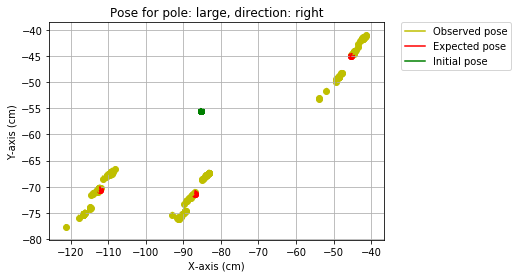

In [3]:
poles = ['small', 'medium', 'large']
directions = ['straight', 'left', 'right']
gt = [[-86.89, -71.31, 1.45], [-45.47, -45.00, 0.88], [-112.13, -70.58, 1.78]]

df_all = pd.DataFrame(columns=['size', 'direction', 'x', 'y', 'theta'])

for _, pole in enumerate(poles):
    for ind, direction in enumerate(directions):
        df = get_measurements(pole, direction)
        
        # Save data
        output_path = './pre-processed/{}_{}.csv'.format(pole, direction)
        df.to_csv(output_path)
        
        x_mean = np.mean(df.x.values)
        y_mean = np.mean(df.y.values)
        theta_mean = np.mean(df.theta.values)
        
        df_all = df_all.append({'size': pole, 'direction': direction, 'x': x_mean, 'y': y_mean, 'theta': theta_mean}, ignore_index=True)
        
        # Plot data
        title = 'Pose for pole: {}, direction: {}'.format(pole, direction)
        plot_data(df, (gt[ind][0], gt[ind][1], gt[ind][2]), title, False)
        
df_all.to_csv('./pre-processed/all.csv')
plt.show()

In [29]:
def get_ground_truth():
    return {'straight': [-86.89, -71.31, 1.45], 
          'left': [-45.47, -45.00, 0.88], 
          'right': [-112.13, -70.58, 1.78]
         }

def scatter_plot_in_direction(direction):
    # ground truth
    gt = get_ground_truth()
        
    pole = 'small'
    title = 'Pose for pole: {}, direction: {}'.format(pole, direction)
    df = get_measurements(pole, direction)
    plot_data(df, (gt[direction][0], gt[direction][1], gt[direction][2]), title)

    pole = 'medium'
    title = 'Pose for pole: {}, direction: {}'.format(pole, direction)
    df = get_measurements(pole, direction)
    plot_data(df, (gt[direction][0], gt[direction][1], gt[direction][2]), title)

    pole = 'large'
    title = 'Pose for pole: {}, direction: {}'.format(pole, direction)
    df = get_measurements(pole, direction)
    plot_data(df, (gt[direction][0], gt[direction][1], gt[direction][2]), title)

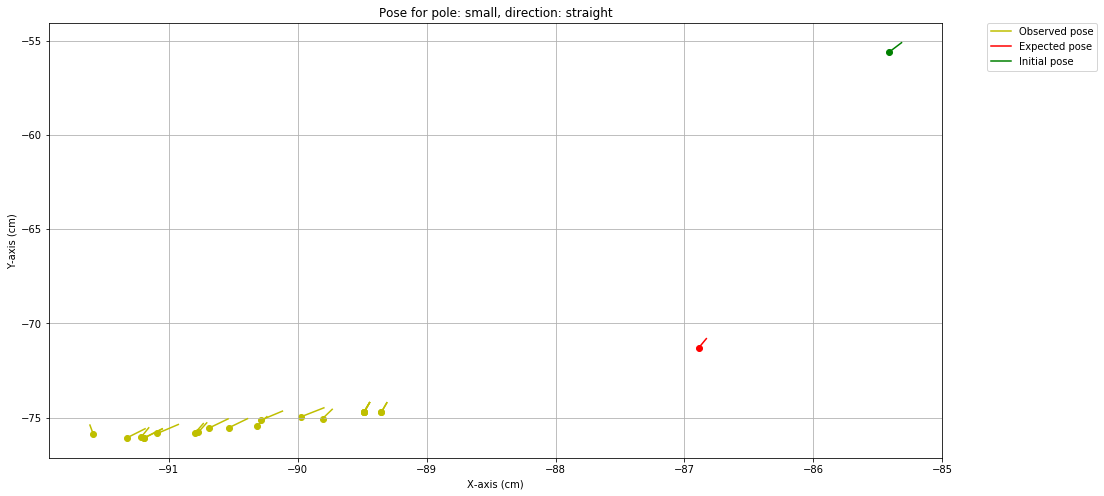

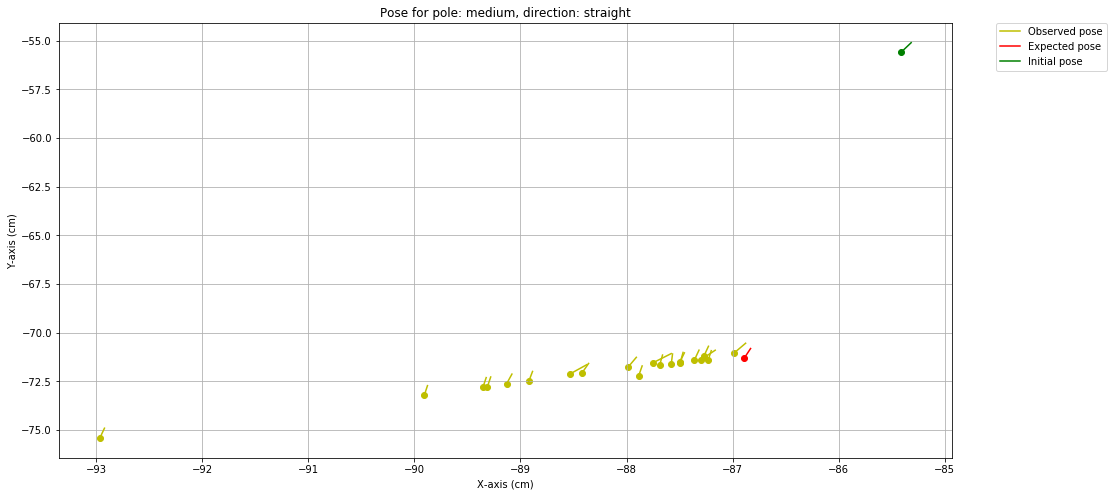

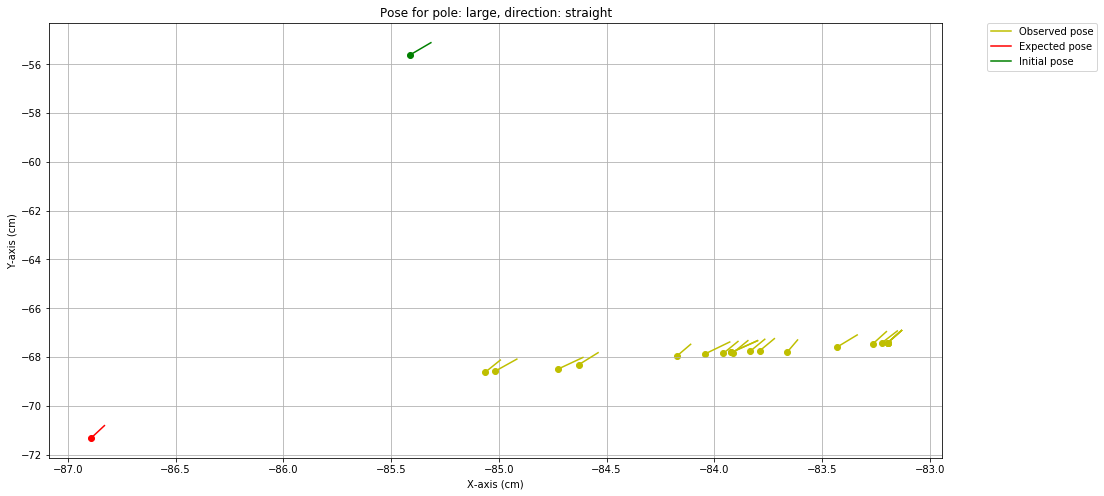

In [30]:
scatter_plot_in_direction('straight')

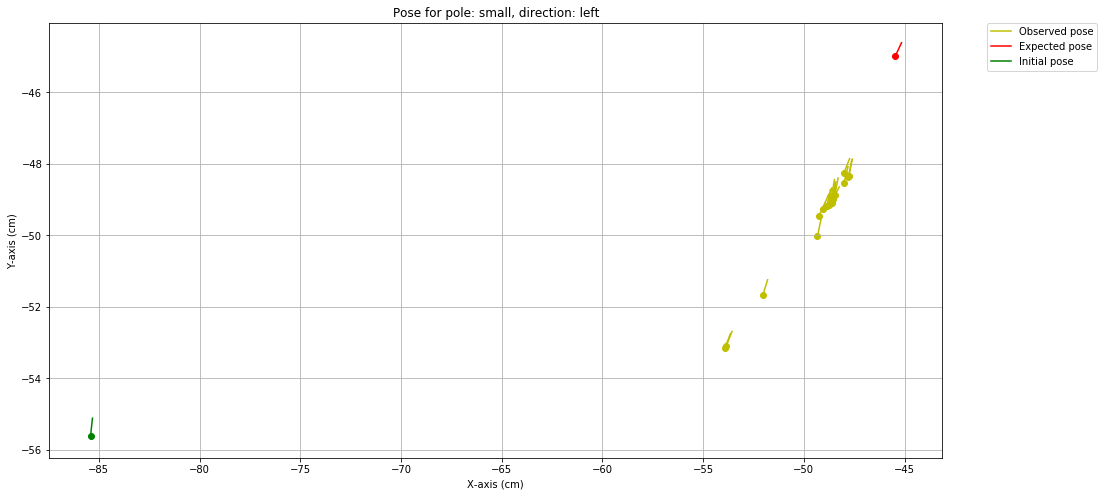

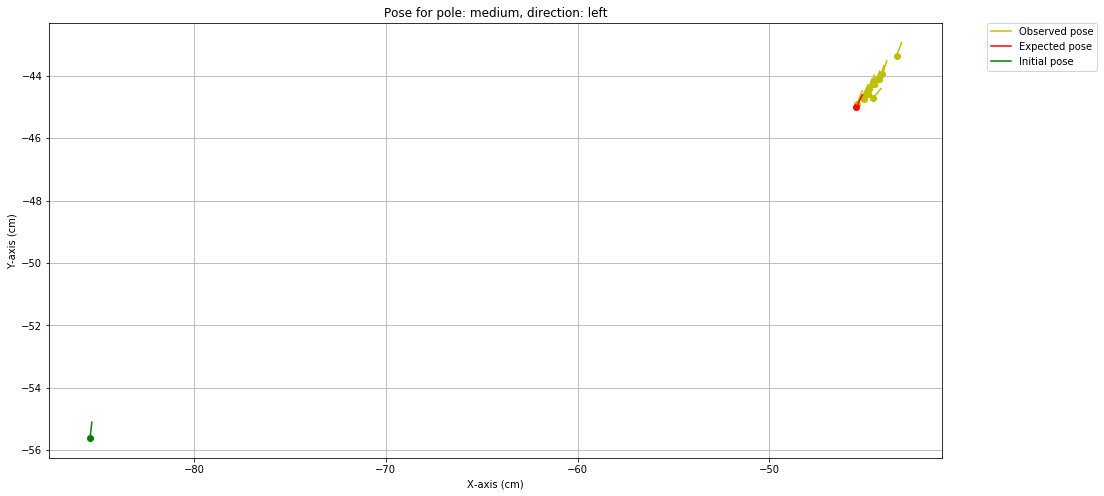

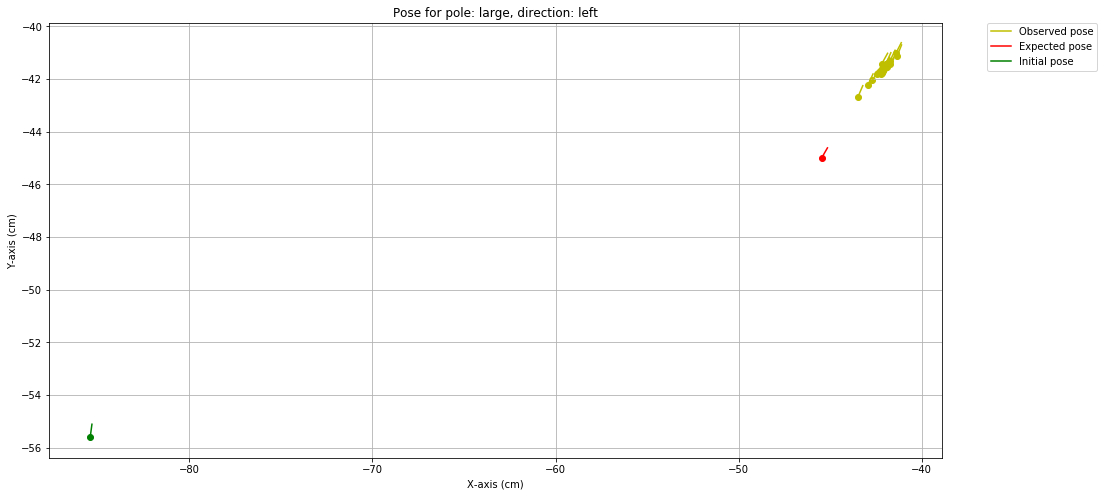

In [31]:
scatter_plot_in_direction('left')

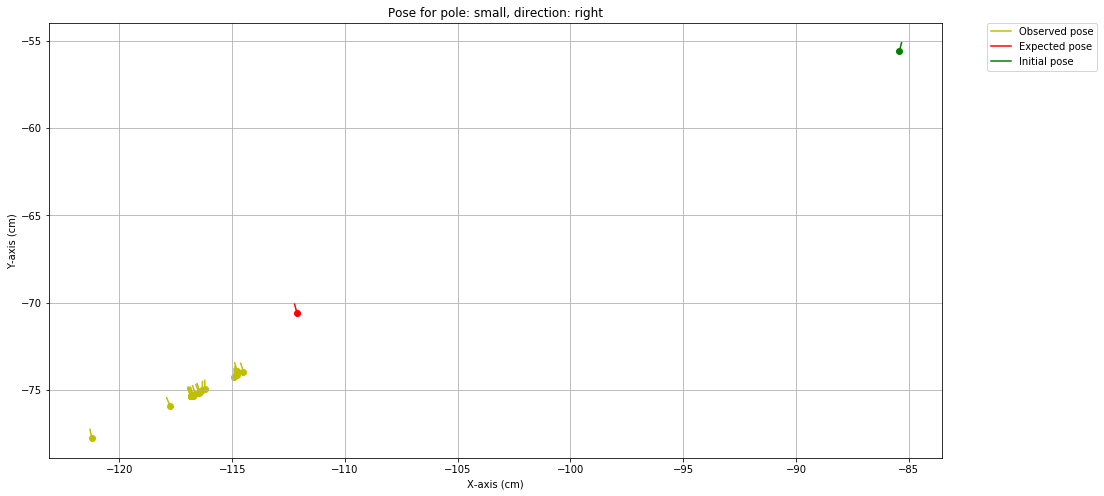

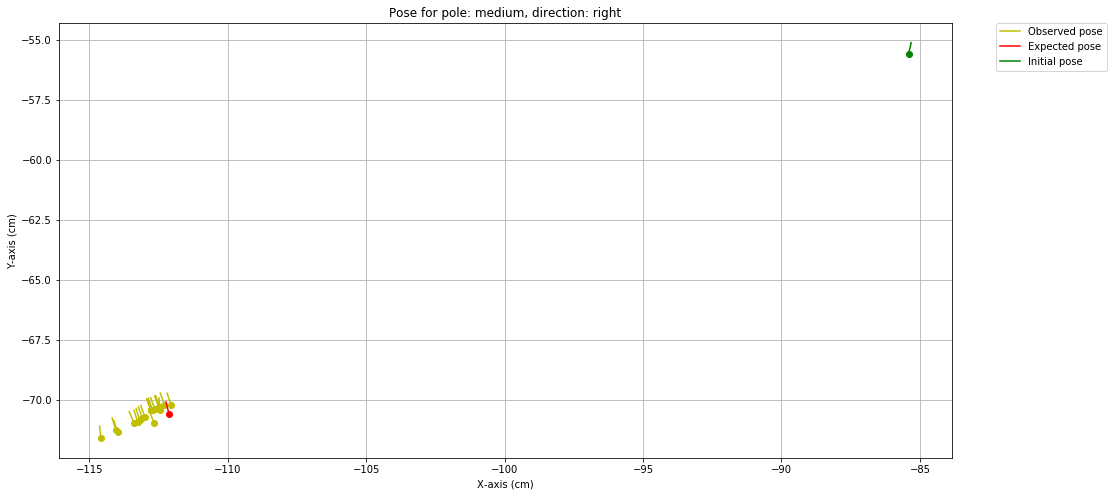

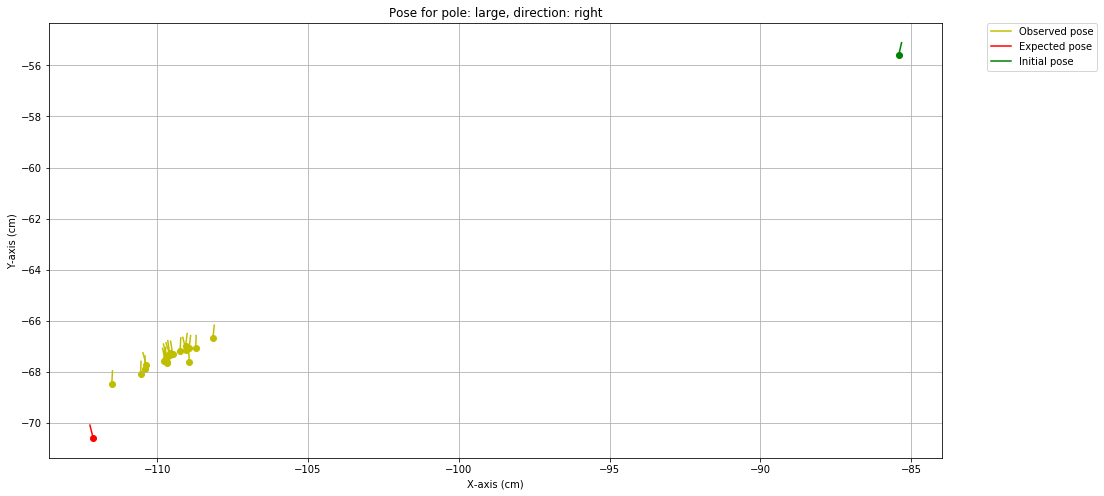

In [32]:
scatter_plot_in_direction('right')

In [55]:
def bar_chart_in_direction(direction):
    pole = 'small'
    df_small = get_measurements(pole, direction)

    pole = 'medium'
    df_medium = get_measurements(pole, direction)

    pole = 'large'
    df_large = get_measurements(pole, direction)

    df_all = pd.DataFrame(columns=['x','y', 'theta'])

    df_all = df_all.append(df_small)
    df_all = df_all.append(df_medium)
    df_all = df_all.append(df_large)

    fig = plt.figure(figsize=(16,16))

    ax = plt.subplot(321)
    sns.distplot(df_small.x.values,hist=True, rug=True,
                 label='pole: {}, direction: {}'.format('small', direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(322)
    sns.distplot(df_small.y.values,hist=True, rug=True,
                 label='pole: {}, direction: {}'.format('small', direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()


    ax = plt.subplot(323)
    sns.distplot(df_medium.x.values,hist=True, rug=True,
                 label='pole: {}, direction: {}'.format('medium', direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(324)
    sns.distplot(df_medium.y.values,hist=True, rug=True,
                 label='pole: {}, direction: {}'.format('medium', direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()


    ax = plt.subplot(325)
    sns.distplot(df_large.x.values,hist=True, rug=True,
                 label='pole: {}, direction: {}'.format('large', direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(326)
    sns.distplot(df_large.y.values,hist=True, rug=True,
                 label='pole: {}, direction: {}'.format('large', direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    plt.show()


    ax = plt.subplot(121)
    sns.distplot(df_all.x.values,hist=True, rug=True,
                 label='pole: {}, direction: {}'.format('ALL', direction))
    plt.title('X coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    ax = plt.subplot(122)
    sns.distplot(df_all.y.values,hist=True, rug=True,
                 label='pole: {}, direction: {}'.format('ALL', direction))
    plt.title('Y coordinates')
    plt.ylabel('Probability density')
    plt.xlabel('Distance (cm)')
    plt.legend()

    plt.show()

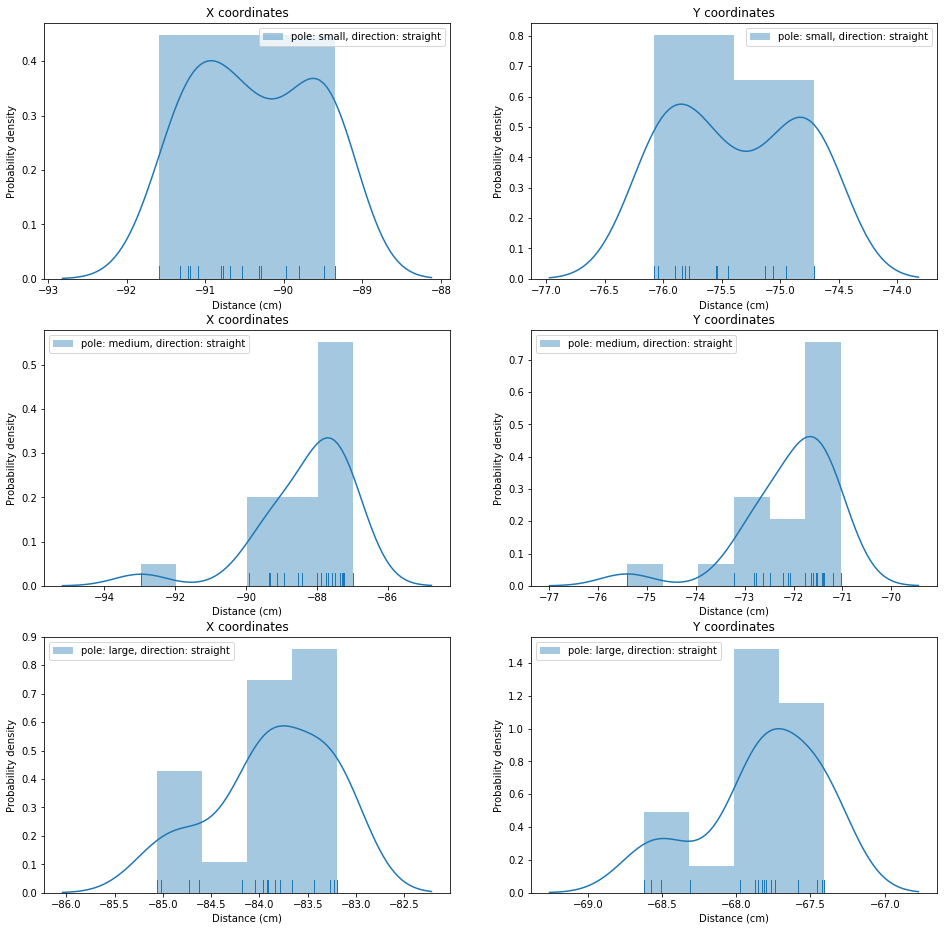

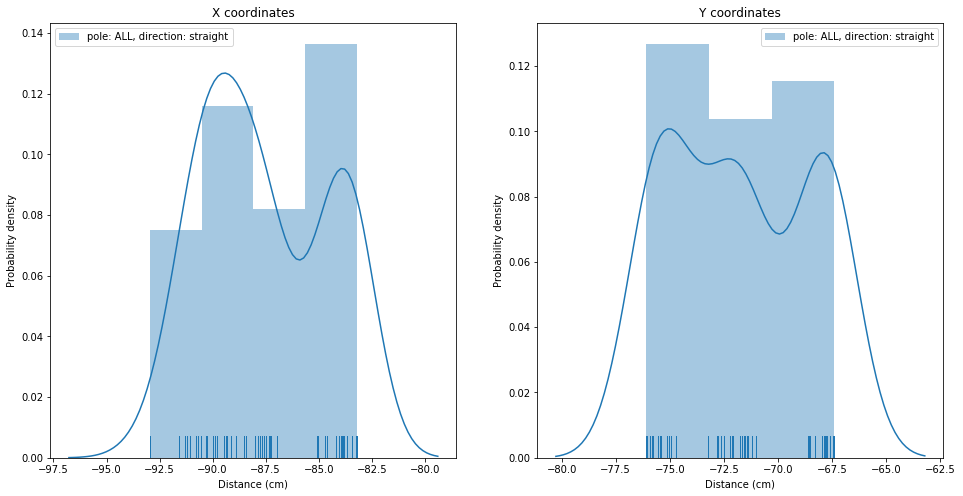

In [56]:
bar_chart_in_direction('straight')

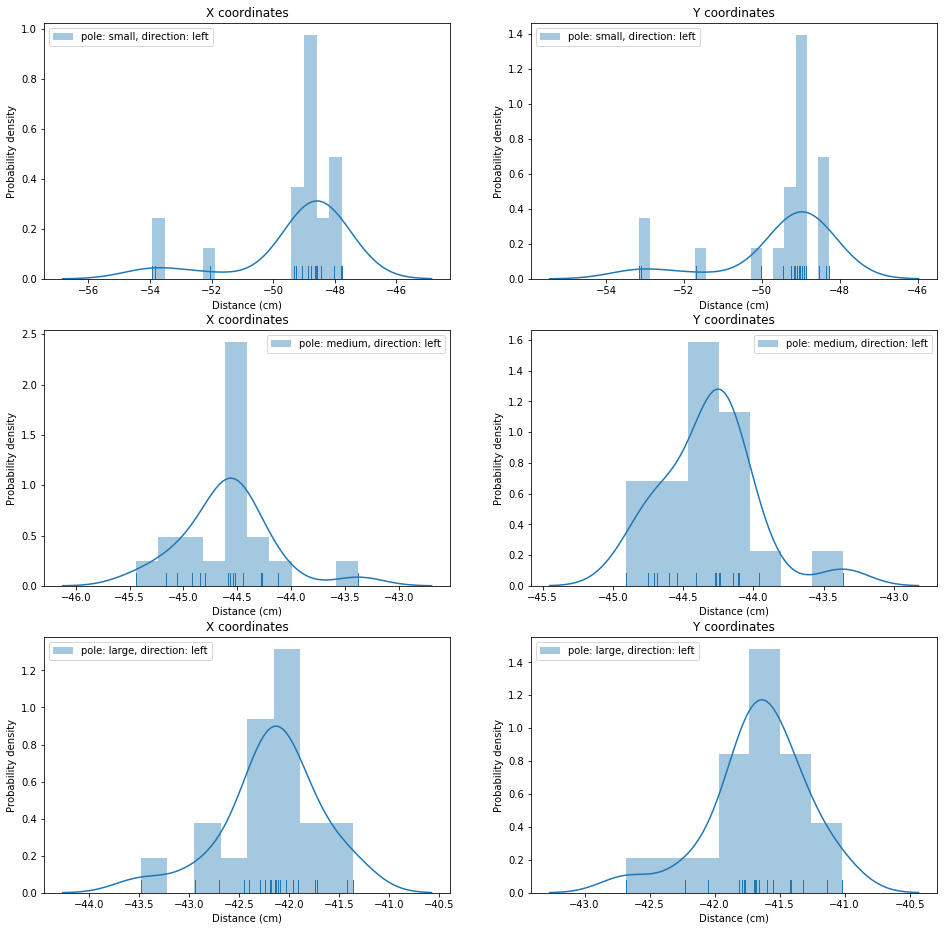

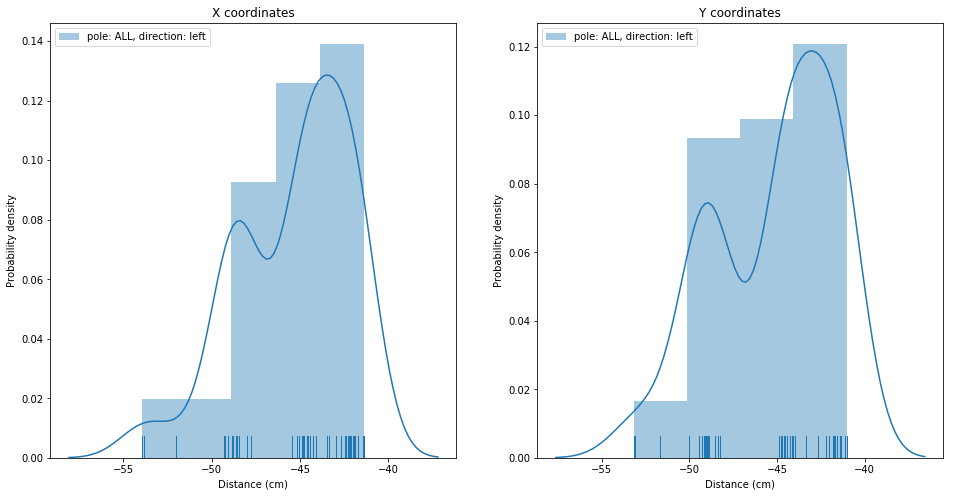

In [57]:
bar_chart_in_direction('left')

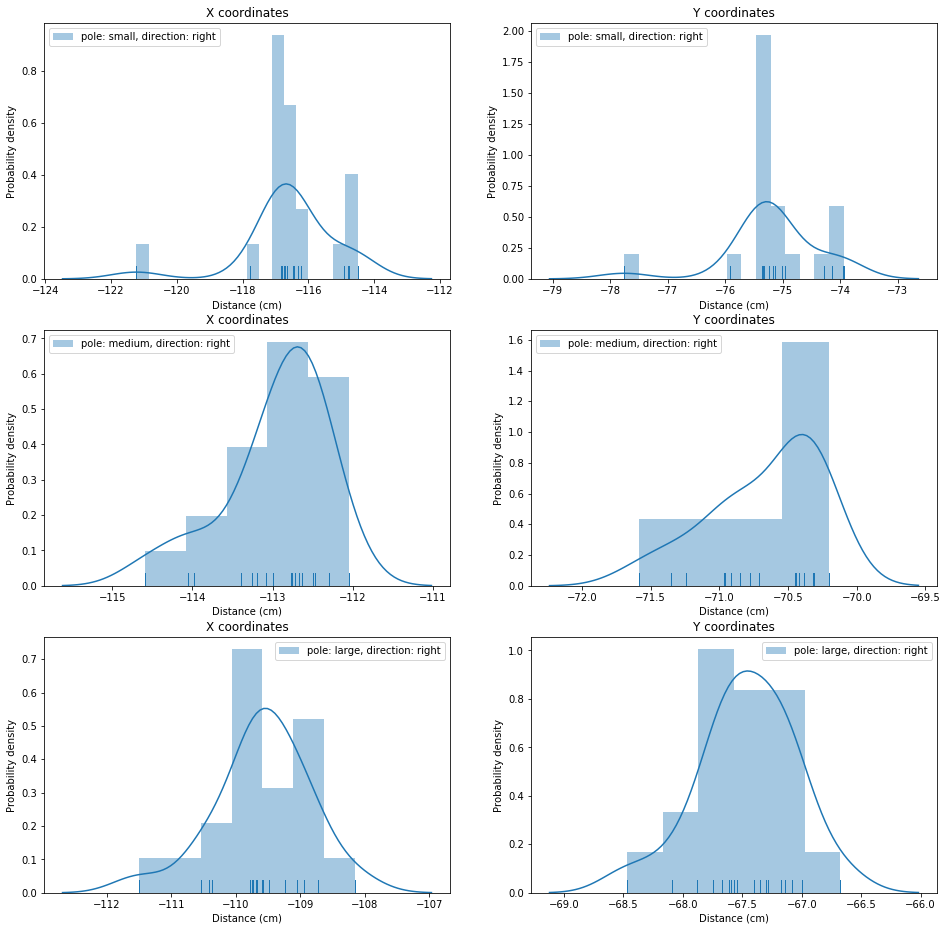

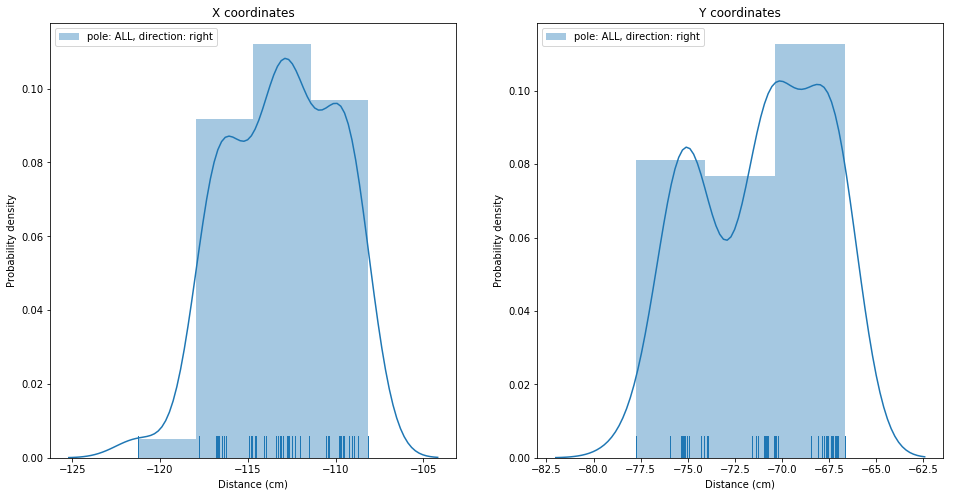

In [58]:
bar_chart_in_direction('right')

In [64]:
def print_mean_in_direction(direction):
    pole = 'small'
    df_small = get_measurements(pole, direction)

    pole = 'medium'
    df_medium = get_measurements(pole, direction)

    pole = 'large'
    df_large = get_measurements(pole, direction)

    df_all = pd.DataFrame(columns=['x','y', 'theta'])

    df_all = df_all.append(df_small)
    df_all = df_all.append(df_medium)
    df_all = df_all.append(df_large)

    mean = df_small.mean(axis=0)
    print 'small: ', mean.x, mean.y, mean.theta

    mean = df_medium.mean(axis=0)
    print 'medium: ', mean.x, mean.y, mean.theta 

    mean = df_large.mean(axis=0)
    print 'large: ', mean.x, mean.y, mean.theta 

    mean = df_all.mean(axis=0)
    print 'all: ', mean.x, mean.y, mean.theta 

In [65]:
print_mean_in_direction('straight')

small:  -90.37051237047415 -75.37836228481024 1.3908199327238708
medium:  -88.32793401146778 -72.087457369144 1.451267805993687
large:  -83.86764770420817 -67.82922197061546 1.4096470296709716
all:  -87.52203136205003 -71.76501387485658 1.4172449227961768


In [66]:
print_mean_in_direction('left')

small:  -49.27287538071531 -49.5254052306991 1.1264724250190736
medium:  -44.58756261704538 -44.31763739318007 0.8416772048430461
large:  -42.17442399003024 -41.662273846465354 0.9175709665642501
all:  -45.34495399593031 -45.16843882344816 0.9619068654754563


In [67]:
print_mean_in_direction('right')

small:  -116.56248006573833 -75.18439225790806 1.7907309894740493
medium:  -112.95615896365102 -70.66389457362327 1.8487609363759492
large:  -109.5953512217854 -67.4641741377532 1.6291928713572381
all:  -113.03799675039157 -71.1041536564282 1.756228265735746
